In [1]:
import torch
import deepxde as dde

%cd ..
from models import FNO2d
from train_utils.datasets import MatReader, TrafficLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


/home/jw3275/PI-FNO-reproduce


<h2>Load model</h2>

In [2]:
config = {"model": {
              "layers": [100, 100, 100, 100, 100], #[16, 24, 24, 32, 32],
              "modes1": [15, 12, 9, 9],
              "modes2": [15, 12, 9, 9],
              "fc_dim": 128,
              "act": "gelu",
              "num_pad": 4,
            },
          }

In [3]:
model = FNO2d(modes1=config['model']['modes1'],
              modes2=config['model']['modes2'],
              fc_dim=config['model']['fc_dim'],
              layers=config['model']['layers'],
              act=config['model']['act']).to(device)

ckpt_path = "/home/jw3275/PI-FNO-reproduce/checkpoints/traffic-FDM/traffic-data-1-pde-00001-ic-0-100-5.pt"
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

<h2>Generate Ground Truths</h2>

Generating 100 samples of time-dependent traffic equation ...
Processing sample 50/100...
Processing sample 100/100...

Generation complete.
x shape: (100, 128)
y shape: (100, 101, 128)


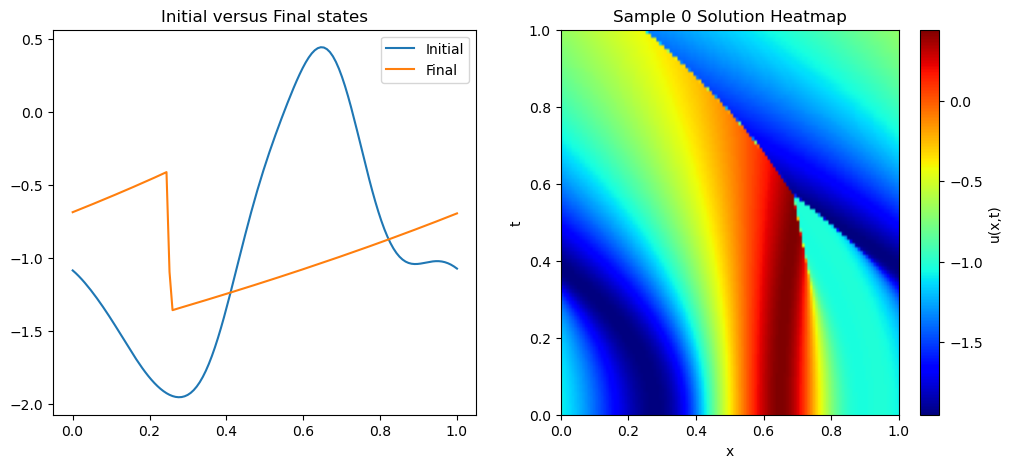

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def solve_t_traffic_sharp(u0, x_max=1.0, t_max=1.0, Nx=500, Nt=None, cfl=0.8, plot=False):
    dx = x_max / Nx
    x = np.linspace(0, x_max, Nx, endpoint=False)
    
    # Estimate dt based on max possible wave speed (approx 0.5 for this traffic model)
    # and max time t_max.
    if Nt is None:
        max_speed_est = t_max * 0.5 
        dt = cfl * dx / max_speed_est
        Nt = int(t_max / dt) + 1
    else:
        dt = t_max / (Nt - 1)

    # --- Physics Functions ---
    def g_flux_spatial(u):
        return (u**2)/2.0 - (u**3)/6.0
    
    def g_prime_spatial(u):
        return u - (u**2)/2.0

    # --- Minmod Slope Limiter (The key to sharpness) ---
    def minmod(a, b):
        return np.where(np.abs(a) < np.abs(b), a, b) * (np.sign(a) == np.sign(b))

    u = u0
    sols = [u.copy()]

    for n in range(Nt):
        current_time = n * dt
        
        # --- 1. Slope Reconstruction ---
        # Get neighbors with periodic boundary conditions
        u_minus = np.roll(u, 1)
        u_plus  = np.roll(u, -1)
        
        # Calculate slopes (difference between neighbors)
        slope_L = (u - u_minus) / dx
        slope_R = (u_plus - u) / dx
        
        # Apply Limiter to avoid oscillations at shocks
        sigma = minmod(slope_L, slope_R)
        
        # Reconstruct values at the boundaries (Left and Right of the interface)
        # u_L_interface is the value at i+1/2 coming from cell i
        # u_R_interface is the value at i+1/2 coming from cell i+1
        u_L_interface = u + 0.5 * dx * sigma
        u_R_interface = u_plus - 0.5 * dx * np.roll(sigma, -1)
        
        # --- 2. Rusanov Flux using RECONSTRUCTED values ---
        flux_L = g_flux_spatial(u_L_interface)
        flux_R = g_flux_spatial(u_R_interface)
        
        # Calculate wave speed (alpha) using the max speed at the interface
        # We check both sides of the interface to be safe
        speed_L = np.abs(g_prime_spatial(u_L_interface))
        speed_R = np.abs(g_prime_spatial(u_R_interface))
        alpha = current_time * np.maximum(speed_L, speed_R)
        
        # Rusanov Flux Formula
        F_interface = 0.5 * (current_time * (flux_L + flux_R) - alpha * (u_R_interface - u_L_interface))
        
        # --- 3. Update Solution ---
        dF = F_interface - np.roll(F_interface, 1)
        u = u - (dt / dx) * dF
        
        sols.append(u.copy())

    if plot:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(x, sols[-1], label="High-Res Solution", color='red')
        plt.plot(x, ic(x), '--', label="Initial condition", color='gray', alpha=0.5)
        plt.title(r'Sharper Solution (MUSCL)')
        plt.legend()
        plt.grid()

        plt.subplot(1,2,2)
        plt.imshow(sols, extent=[0, x_max, 0, t_max], origin="lower", aspect="auto", cmap="jet")
        plt.colorbar()
        plt.show()

    return np.array(sols)

def create_traffic_dataset(N_SAMPLES=200, Nx=128, Nt=101, X_MUL=4, T_MUL=5, LENGTH_SCALE=1.0, ics=None):
    """
    Generates dataset and returns dictionary with NumPy arrays.
    """
    print(f"Generating {N_SAMPLES} samples of time-dependent traffic equation ...")
    
    # Pre-allocate arrays
    x_data = np.zeros((N_SAMPLES, Nx))      # To store Initial Conditions
    y_data = np.zeros((N_SAMPLES, Nt, Nx))  # To store Solutions

    func_space = dde.data.GRF(kernel="ExpSineSquared", length_scale=LENGTH_SCALE)
    feats = func_space.random(N_SAMPLES)

    xs = np.linspace(0, 1, Nx*X_MUL)
    if ics is not None:
        ics_all = np.zeros((N_SAMPLES, Nx*X_MUL))
        # interpolate ics to match the resolution
        x_res = ics.shape[1]
        x_grid = np.linspace(0, 1, x_res+1, endpoint=True)
        for k in range(N_SAMPLES):
            ic_pad = np.append(ics[k], ics[k][0])
            ic = interp1d(x_grid, ic_pad, "linear")
            ics_all[k] = ic(xs)

    else:  
        ics_all = func_space.eval_batch(feats, xs)
    
    for i in range(N_SAMPLES):
        if (i+1) % 50 == 0:
            print(f"Processing sample {i+1}/{N_SAMPLES}...")
            
        # 1. Generate IC
        u0 = ics_all[i]
        
        # 2. Solve
        u_sol = solve_t_traffic_sharp(u0, Nx=Nx*X_MUL, Nt=(Nt-1)*T_MUL+1)
        
        # 3. Store
        x_data[i] = u0[::X_MUL]
        y_data[i] = u_sol[::T_MUL, ::X_MUL]

    # 4. Pack into dictionary (NumPy arrays only)
    traffic_128 = {
        'x': x_data,
        'y': y_data,
        'visc': np.array([[0]])
    }
    
    print("\nGeneration complete.")
    print(f"x shape: {traffic_128['x'].shape}")
    print(f"y shape: {traffic_128['y'].shape}")
    
    return traffic_128

# --- Example Usage ---
if __name__ == "__main__":
    # Generate data
    data_dict = create_traffic_dataset(N_SAMPLES=100, Nx=128, Nt=101, X_MUL=4, T_MUL=50)
    
    # Verification Plot
    sample_idx = np.random.randint(1)
    x_grid = np.linspace(0, 1, 128)
    u_field = data_dict['y'][sample_idx]
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)    
    plt.plot(x_grid, u_field[0], label="Initial")
    plt.plot(x_grid, u_field[-1], label="Final")
    plt.title("Initial versus Final states")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.imshow(u_field, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
    plt.colorbar(label="u(x,t)")
    plt.title(f"Sample {sample_idx} Solution Heatmap")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.show()

In [ ]:
# # Generate data
# data_dict = create_traffic_dataset(N_SAMPLES=1000, Nx=128, Nt=101, X_MUL=4, T_MUL=50)

# import scipy

# # We map 'x' -> 'input' and 'y' -> 'output'
# mat_data = {
#     'input': data_dict['x'],
#     'output': data_dict['y'],
#     'visc': data_dict['visc']
# }

# # 3. Save to .mat file
# # do_compression=True helps if the arrays are large
# scipy.io.savemat('/home/tp526/neuraloperator/data/traffic_pino.mat', mat_data, do_compression=True)

# print("Saved to /home/tp526/neuraloperator/data/traffic_pino.mat")

Generating 1000 samples of time-dependent traffic equation ...
Processing sample 50/1000...
Processing sample 100/1000...
Processing sample 150/1000...
Processing sample 200/1000...
Processing sample 250/1000...
Processing sample 300/1000...
Processing sample 350/1000...
Processing sample 400/1000...
Processing sample 450/1000...
Processing sample 500/1000...
Processing sample 550/1000...
Processing sample 600/1000...
Processing sample 650/1000...
Processing sample 700/1000...
Processing sample 750/1000...
Processing sample 800/1000...
Processing sample 850/1000...
Processing sample 900/1000...
Processing sample 950/1000...
Processing sample 1000/1000...

Generation complete.
x shape: (1000, 128)
y shape: (1000, 101, 128)
Saved to /home/tp526/neuraloperator/data/traffic_pino.mat


<h2>Test the model</h2>

In [5]:
def format_burgers_data(data_dict):
    """
    Reshapes the Burgers dataset into a coordinate-based format.
    
    Args:
        data_dict (dict): Dictionary with keys 'x' (N, Nx) and 'y' (N, Nt, Nx).
        
    Returns:
        np.array: A single array of shape (N_SAMPLES, Nt, Nx, 3).
                  Channel 0: u0(x) repeated over time
                  Channel 1: x coordinates
                  Channel 2: t coordinates
    """
    # 1. Extract dimensions
    # data_dict['x'] is the initial condition u0, shape (N, Nx)
    # data_dict['y'] is the solution u, shape (N, Nt, Nx)
    u0 = data_dict['x'] 
    N_samples, Nx = u0.shape
    Nt = data_dict['y'].shape[1]
    
    print(f"Dimensions detected: N={N_samples}, Nt={Nt}, Nx={Nx}")

    # 2. Create Mesh Grids (Nt, Nx)
    # Recreate the grids used in the solver
    x_1d = np.linspace(0, 1, Nx, endpoint=False)
    t_1d = np.linspace(0, 1, Nt)
    
    # Create 2D grids. indexing='ij' ensures output is (Nt, Nx)
    # T_grid varies along axis 0, X_grid varies along axis 1
    T_grid, X_grid = np.meshgrid(t_1d, x_1d, indexing='ij')
    
    # 3. Broadcast/Repeat Arrays to shape (N, Nt, Nx)
    
    # Channel 0: u0 (Initial Condition)
    # Input: (N, Nx) -> Expand to (N, 1, Nx) -> Tile to (N, Nt, Nx)
    u0_expanded = np.tile(u0[:, None, :], (1, Nt, 1))
    
    # Channel 1: X Grid
    # Input: (Nt, Nx) -> Expand to (1, Nt, Nx) -> Broadcast to (N, Nt, Nx)
    X_expanded = np.tile(X_grid[None, :, :], (N_samples, 1, 1))
    
    # Channel 2: T Grid
    # Input: (Nt, Nx) -> Expand to (1, Nt, Nx) -> Broadcast to (N, Nt, Nx)
    T_expanded = np.tile(T_grid[None, :, :], (N_samples, 1, 1))
    
    # 4. Stack along the last axis
    # Result shape: (N, Nt, Nx, 3, 1)
    formatted_data = np.stack([u0_expanded, X_expanded, T_expanded], axis=-1)
    
    return formatted_data

In [6]:
formatted_inputs = format_burgers_data(data_dict)
formatted_inputs.shape

Dimensions detected: N=100, Nt=101, Nx=128


(100, 101, 128, 3)

Input shape:  torch.Size([1, 101, 128, 3])
Output shape:  torch.Size([1, 101, 128])


==Relative L2 error mean:  0.038710==

Ground Truth


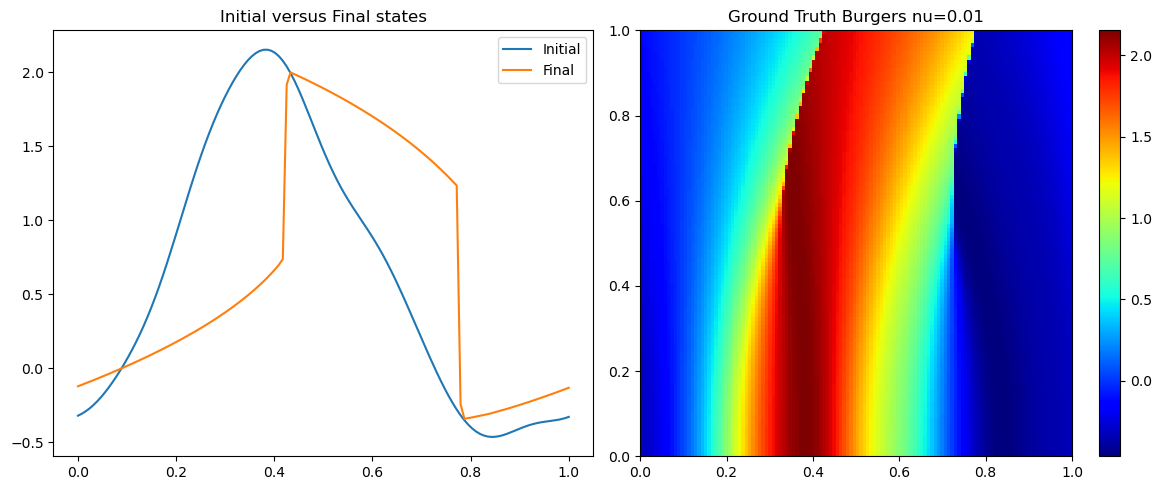

Prediction


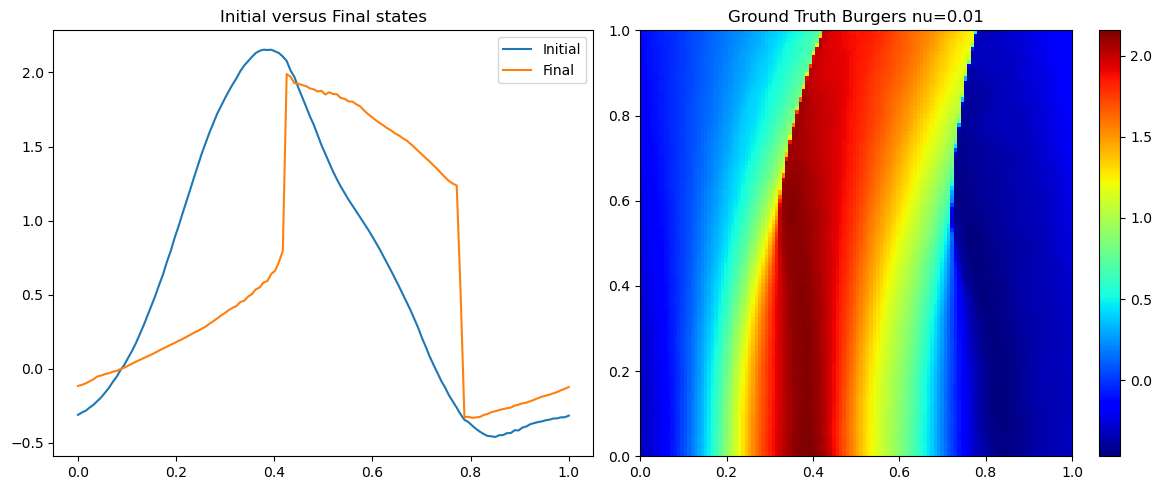

In [7]:
k = np.random.randint(10)

x, y = torch.tensor(formatted_inputs[k:k+1], dtype=torch.float32).to(device), torch.tensor(data_dict["y"][k:k+1], dtype=torch.float32).to(device)

print("Input shape: ", x.shape)
print("Output shape: ", y.shape)
print("\n")

out = model(x).reshape(y.shape)

data_loss = torch.norm(out - y) / torch.norm(y)

print(f'==Relative L2 error mean: {data_loss.item() : .6f}==\n')

# Plot
print("Ground Truth")
truth = y[0].detach().cpu().numpy()
x_grid = np.linspace(0, 1, truth.shape[1])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_grid, truth[0], label="Initial")
plt.plot(x_grid, truth[-1], label="Final")
plt.title("Initial versus Final states")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(truth, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
plt.title("Ground Truth Burgers nu=0.01")
plt.colorbar()

plt.tight_layout()
plt.show()

print("Prediction")
pred = out[0].detach().cpu().numpy()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_grid, pred[0], label="Initial")
plt.plot(x_grid, pred[-1], label="Final")
plt.title("Initial versus Final states")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(pred, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
plt.title("Ground Truth Burgers nu=0.01")
plt.colorbar()

plt.tight_layout()
plt.show()



In [31]:
dataset = BurgersLoader("/home/tp526/neuraloperator/data/burgers_pino.mat",
                            nx=128, nt=100,
                            sub=1, sub_t=1, new=True)
train_loader = dataset.make_loader(n_sample=10,
                                    batch_size=1,
                                    start=0)

/home/tp526/.conda/envs/dde/lib/python3.11/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [32]:
for batch in train_loader:
    x, y = batch
    print(x.shape)

torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])


In [9]:
import scipy

# We map 'x' -> 'input' and 'y' -> 'output'
mat_data = {
    'input': data_dict['x'],
    'output': data_dict['y'],
    'visc': data_dict['visc']
}

# 3. Save to .mat file
# do_compression=True helps if the arrays are large
scipy.io.savemat('/home/tp526/neuraloperator/data/traffic_pino.mat', mat_data, do_compression=True)

print("Saved to /home/tp526/neuraloperator/data/traffic_pino.mat")

Saved to /home/tp526/neuraloperator/data/traffic_pino.mat


In [23]:
print("-" * 100)
print("\nNumber of trainable parameters: ", sum(p.numel() for p in model.parameters()))
print("\n" + "-" * 100)

----------------------------------------------------------------------------------------------------

Number of trainable parameters:  3715777

----------------------------------------------------------------------------------------------------


<h2>Test</h2>

In [8]:
#model.eval()

N_CASE = formatted_inputs.shape[0]

l2_errors = np.zeros(N_CASE)
l1_errors = np.zeros(N_CASE)

with torch.no_grad():
    for k in range(N_CASE):
        x = torch.tensor(formatted_inputs[k:k+1], dtype=torch.float32).to(device)
        y = torch.tensor(data_dict["y"][k:k+1], dtype=torch.float32).to(device)

        out = model(x).reshape(y.shape)

        # Relative L2
        l2 = torch.norm(out - y, p=2) / torch.norm(y, p=2)
        l2_errors[k] = l2.item()

        # Relative L1
        l1 = torch.norm(out - y, p=1) / torch.norm(y, p=1)
        l1_errors[k] = l1.item()

        if (k+1) % 20 == 0:
            print(f'Sample {k+1}/{N_CASE}: ')
            print(f'    Mean L2-relative-error: {np.mean(l2_errors[:(k+1)]):.6e}')
            print(f'    Mean L1-relative-error: {np.mean(l1_errors[:(k+1)]):.6e}')
            print("-" * 50 + "\n")

print(f"Mean L2-relative-error over 100 tests: {np.mean(l2_errors):.6e}")
print(f"Mean L1-relative-error over 100 tests: {np.mean(l1_errors):.6e}")
print(f"L2 std: {np.std(l2_errors):.6e}")
print(f"L1 std: {np.std(l1_errors):.6e}")


Sample 20/100: 
    Mean L2-relative-error: 3.237443e-02
    Mean L1-relative-error: 1.005253e-02
--------------------------------------------------

Sample 40/100: 
    Mean L2-relative-error: 3.710744e-02
    Mean L1-relative-error: 1.245445e-02
--------------------------------------------------

Sample 60/100: 
    Mean L2-relative-error: 3.655243e-02
    Mean L1-relative-error: 1.177022e-02
--------------------------------------------------

Sample 80/100: 
    Mean L2-relative-error: 4.015559e-02
    Mean L1-relative-error: 1.290303e-02
--------------------------------------------------

Sample 100/100: 
    Mean L2-relative-error: 4.102566e-02
    Mean L1-relative-error: 1.317758e-02
--------------------------------------------------

Mean L2-relative-error over 100 tests: 4.102566e-02
Mean L1-relative-error over 100 tests: 1.317758e-02
L2 std: 3.175175e-02
L1 std: 1.165397e-02
